<a href="https://colab.research.google.com/github/axel-sirota/practical-nlp/blob/main/2-classification/Practical_NLP_7_NewsClassification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
!nvidia-smi

Sat Oct 15 02:20:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |   1140MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [72]:
!pip install textblob 'gensim==4.2.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
import multiprocessing
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, ELU, Conv1D, MaxPooling1D, Dropout
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
import numpy as np
import random
import os
import pandas as pd
import gensim
import warnings
import nltk
import pickle
from tensorflow.nn import leaky_relu

import re
import warnings
from sklearn.model_selection import train_test_split
from textblob import TextBlob


TRACE = False
embedding_dim = 300
n_channels = 64
p_dropout = 0.2
epochs=1000
batch_size = 500
corpus_size=100000
BATCH = True

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config) 
  K.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')
tokenizer = lambda x: TextBlob(x).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
%%writefile get_data.sh
if [ ! -f news.csv ]; then
  wget -O news.csv https://www.dropbox.com/s/352x7xzivf60zgc/news.csv?dl=0
fi

if [ ! -f emb_word2vec_format.txt ]; then
    wget -O emb_word2vec_format.txt https://www.dropbox.com/s/cqoacnovxsq1zoe/emb_word2vec_format.txt?dl=0
fi

Overwriting get_data.sh


In [75]:
!bash get_data.sh

In [76]:
path = './news.csv'
news = pd.read_csv(path, header=0).sample(n=corpus_size).reset_index(drop=True)

In [77]:
def preprocess_text(text, should_join=True):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    if should_join:
      return ' '.join(gensim.utils.simple_preprocess(text))
    else:
      return gensim.utils.simple_preprocess(text)

In [78]:
news.title.apply(preprocess_text)
news

,category,title
0,Business,"BBC set for major shake-up, claims newspaper"
1,Business,Marsh averts cash crunch
2,Sports,"Jeter, Yankees Look to Take Control (AP)"
3,Sci/Tech,Flying the Sun to Safety
4,Business,Stocks Seen Flat as Nortel and Oil Weigh
...,...,...
99995,Sports,"Raptors 94, Heat 92"
99996,Sci/Tech,The Making of an X Box Warrior
99997,Sports,Turner confident Illini can rebound from 35-17...
99998,Business,Intel lifts forecast


In [79]:
from gensim.test.utils import datapath
from gensim import utils

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = 'news.csv'
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield preprocess_text(line, should_join=False)

import gensim.models

sentences = MyCorpus()
word2vec = gensim.models.Word2Vec(sentences=sentences, vector_size=embedding_dim)
word2vec_model = word2vec.wv

In [80]:
news['label'] = news.category.map({'Business': 0, 'Sports': 1, 'Sci/Tech': 2, 'World': 3})

weights = tf.constant(word2vec_model.vectors)
vocab_size = len(word2vec_model.index_to_key)

In [81]:
weights.shape

TensorShape([12343, 300])

In [82]:
def get_maximum_review_length(df):
    maximum = 0
    for ix, row in df.iterrows():
        candidate = len(tokenizer(row.title))
        if candidate > maximum:
            maximum = candidate
    return maximum


maximum = get_maximum_review_length(news)

In [83]:
X = np.zeros((len(news), maximum))
for index, row in news.iterrows():
    ix = 0
    for word in tokenizer(row.title):
        if word not in word2vec_model:
            representation = 0
        else:
            representation = word2vec_model.index_to_key.index(word)
        X[index, ix] = representation
        ix += 1
y = news.label

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = tf.constant(X_train)
X_test = tf.constant(X_test)
y_train = tf.one_hot(tf.constant(y_train), 4)
y_test = tf.one_hot(tf.constant(y_test), 4)

In [85]:
X_train[0]

<tf.Tensor: shape=(23,), dtype=float64, numpy=
array([0., 0., 0., 8., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])>

In [86]:
weights.shape

TensorShape([12343, 300])

In [87]:
model = Sequential()
model.add(Embedding(input_dim=weights.shape[0], output_dim=embedding_dim, input_length=maximum, embeddings_initializer=Constant(weights), trainable=True))
model.add(Conv1D(filters=n_channels, kernel_size=3, padding='same', data_format='channels_first'))
model.add(ELU())
model.add(Conv1D(filters=2*n_channels, kernel_size=3, padding='same', data_format='channels_first'))
model.add(ELU())
model.add(Lambda(lambda x: K.mean(x, axis=2)))
model.add(Dense(50, activation=leaky_relu))
model.add(Dropout(rate=p_dropout))
model.add(Dense(4, activation='softmax'))

In [88]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics='accuracy')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 23, 300)           3702900   
                                                                 
 conv1d_19 (Conv1D)          (None, 64, 300)           4480      
                                                                 
 elu_19 (ELU)                (None, 64, 300)           0         
                                                                 
 conv1d_20 (Conv1D)          (None, 128, 300)          24704     
                                                                 
 elu_20 (ELU)                (None, 128, 300)          0         
                                                                 
 lambda_9 (Lambda)           (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 50)              

In [89]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.01)
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), workers=5, callbacks=[callback])

Epoch 1/1000
160/160 [==============================] - 4s 23ms/step - loss: 0.5680 - accuracy: 0.2709 - val_loss: 0.5393 - val_accuracy: 0.3564
Epoch 2/1000
160/160 [==============================] - 4s 22ms/step - loss: 0.5167 - accuracy: 0.3840 - val_loss: 0.5046 - val_accuracy: 0.4129
Epoch 3/1000
160/160 [==============================] - 4s 24ms/step - loss: 0.4897 - accuracy: 0.4357 - val_loss: 0.4900 - val_accuracy: 0.4365
Epoch 4/1000
160/160 [==============================] - 4s 22ms/step - loss: 0.4724 - accuracy: 0.4633 - val_loss: 0.4854 - val_accuracy: 0.4480
Epoch 5/1000
160/160 [==============================] - 3s 22ms/step - loss: 0.4636 - accuracy: 0.4809 - val_loss: 0.4805 - val_accuracy: 0.4646
Epoch 6/1000
160/160 [==============================] - 4s 25ms/step - loss: 0.4549 - accuracy: 0.4945 - val_loss: 0.4767 - val_accuracy: 0.4712
Epoch 7/1000
160/160 [==============================] - 3s 22ms/step - loss: 0.4455 - accuracy: 0.5098 - val_loss: 0.4684 - val_ac

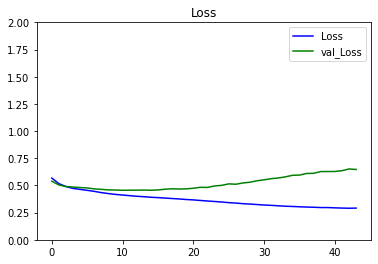

In [90]:
import matplotlib.pyplot as plt

# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=2.0)

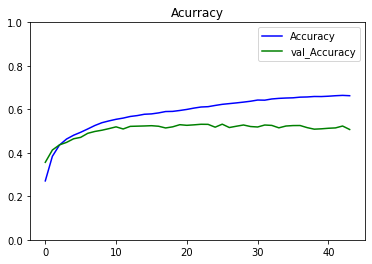

In [91]:
plot_metrics(history.history['accuracy'], history.history['val_accuracy'], "Accuracy", "Acurracy", ylim=1.0)

In [92]:
x_val = np.zeros((2, maximum))
for index, row in enumerate(['supercomputer will put workers jobless soon', 'patriots goes winning super bowl']):
    ix = 0
    for word in tokenizer(row):
        if word not in word2vec_model:
            representation = 0
        else:
            representation = word2vec_model.index_to_key.index(word)
        x_val[index, ix] = representation
        ix += 1
y_val = tf.one_hot([0,1], depth=4)

In [93]:
x_val

array([[ 979.,   56.,  530.,  353.,  977.,  978.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.],
       [ 997.,  309.,  992., 1359.,  991.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]])

In [94]:
y_val

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)>

In [95]:
model.predict(x_val)

1/1 [==============================] - 0s 79ms/step


array([[1.0000000e+00, 3.1376212e-19, 4.7948641e-18, 6.0884120e-18],
       [8.9841837e-01, 1.0061285e-01, 9.6872047e-04, 2.0268128e-14]],
      dtype=float32)

In [96]:
tf.math.argmax(model.predict(x_val), axis=1)

1/1 [==============================] - 0s 17ms/step


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>

In [97]:
tf.math.argmax(model.predict(x_val), axis=1) == tf.math.argmax(y_val, axis=1)

1/1 [==============================] - 0s 20ms/step


<tf.Tensor: shape=(2,), dtype=bool, numpy=array([ True, False])>

In [98]:
model.evaluate(X_test, y_test)

625/625 [==============================] - 2s 3ms/step - loss: 0.6468 - accuracy: 0.5073


[0.6467834711074829, 0.5073000192642212]